In [1]:
# 1.1 Install optional packages if not already installed
# Uncomment and run if needed
# !pip install pandas numpy scikit-learn nltk matplotlib seaborn

# 1.2 Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For modeling
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

# Download NLTK resources once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...


True

In [2]:
def simulate_transaction(record_id):
    # Possible flavours based on Oasis’s style (fruit flavours, some zero sugar)
    flavours = [
        "Summer Fruits", "Citrus Punch", "Tropical", "Mango Medley",
        "Exotic Fruits Zero", "Summer Fruits Zero"
    ]
    flavour = random.choice(flavours)

    # Random date in past year
    month = random.randint(1, 12)
    year = 2024
    date = pd.Timestamp(year=year, month=month, day=random.randint(1,28))

    # Demographics
    age_group = random.choices(
        ["Under 18", "18-24", "25-34", "35-44", "45-54", "55+"],
        weights=[5, 15, 25, 20, 15, 20], k=1
    )[0]
    gender = random.choice(["Female", "Male", "Other"])
    region = random.choice(["London", "Midlands", "North", "South", "Scotland", "Wales"])

    # Sales
    # 500ml or 1.5L
    size = random.choices(["500ml", "1.5L"], weights=[70, 30], k=1)[0]
    # price depends on size
    price = 1.50 if size == "500ml" else 2.50  # synthetic base list price
    # A simple promotion flag
    promo = random.choice([0, 1])  # 1 indicates promotional sale
    if promo:
        price *= 0.9  # 10% discount

    # units sold per transaction—often single bottle, occasionally multipack
    units = random.choices([1,2,3,6,12], weights=[60,15,10,10,5], k=1)[0]

    # Cost assumption
    cost_per_unit = 0.8 if size == "500ml" else 1.4  # synthetic
    # Profit margin
    margin = (price - cost_per_unit) / price

    # Text comment. We’ll create a short synthetic review snippet
    sample_comments = [
        f"Loved the {flavour}, very refreshing!",
        f"{flavour} was too sweet for me.",
        "Great drink for summer days.",
        "Price was good during sale.",
        "Not my favorite flavour.",
        "Perfect with lunch or snacks.",
        "Zero sugar version tasted nice.",
        "Bottle size great for sharing.",
        "Wish it had less sugar.",
        "Family enjoyed it, will buy again."
    ]
    comment = random.choice(sample_comments)

    return {
        "record_id": record_id,
        "date": date,
        "flavour": flavour,
        "size": size,
        "units": units,
        "price_per_unit": round(price, 2),
        "promotion": promo,
        "cost_per_unit": round(cost_per_unit, 2),
        "profit_margin": round(margin, 4),
        "age_group": age_group,
        "gender": gender,
        "region": region,
        "comment": comment
    }

# 2.2 Generate synthetic dataset
n_records = 5000  # adjust for size; 5000 is manageable for demos
data = [simulate_transaction(i) for i in range(1, n_records+1)]
df = pd.DataFrame(data)

# 2.3 Basic sanity checks
df.head()
df.describe(include='all')

,record_id,date,flavour,size,units,price_per_unit,promotion,cost_per_unit,profit_margin,age_group,gender,region,comment
count,5000.000000,5000,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000,5000,5000
unique,NaN,NaN,6,2,NaN,NaN,NaN,NaN,NaN,6,3,6,20
top,NaN,NaN,Exotic Fruits Zero,500ml,NaN,NaN,NaN,NaN,NaN,25-34,Female,South,"Family enjoyed it, will buy again."
freq,NaN,NaN,865,3490,NaN,NaN,NaN,NaN,NaN,1300,1710,868,533
mean,2500.500000,2024-06-29 14:04:07.680000,NaN,NaN,2.409400,1.712670,0.495800,0.981200,0.428802,NaN,NaN,NaN,NaN
min,1.000000,2024-01-01 00:00:00,NaN,NaN,1.000000,1.350000,0.000000,0.800000,0.377800,NaN,NaN,NaN,NaN
25%,1250.750000,2024-04-01 00:00:00,NaN,NaN,1.000000,1.350000,0.000000,0.800000,0.407400,NaN,NaN,NaN,NaN
50%,2500.500000,2024-07-01 00:00:00,NaN,NaN,1.000000,1.500000,0.000000,0.800000,0.440000,NaN,NaN,NaN,NaN
75%,3750.250000,2024-09-27 00:00:00,NaN,NaN,3.000000,2.250000,1.000000,1.400000,0.466700,NaN,NaN,NaN,NaN
max,5000.000000,2024-12-28 00:00:00,NaN,NaN,12.000000,2.500000,1.000000,1.400000,0.466700,NaN,NaN,NaN,NaN


              flavour  units
1  Exotic Fruits Zero   2138
5            Tropical   2070
2        Mango Medley   2036
0        Citrus Punch   1968
4  Summer Fruits Zero   1948
3       Summer Fruits   1887


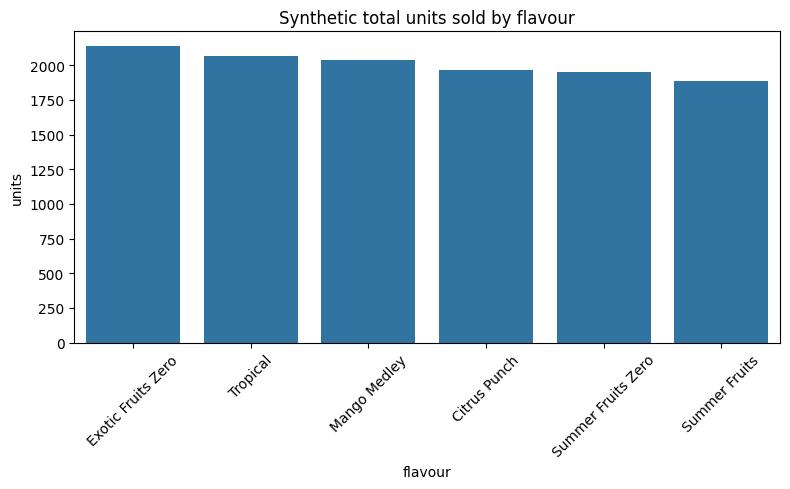

In [3]:
# Units sold by flavour
sales_by_flavour = df.groupby("flavour")["units"].sum().reset_index().sort_values("units", ascending=False)
print(sales_by_flavour)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=sales_by_flavour, x="flavour", y="units")
plt.xticks(rotation=45)
plt.title("Synthetic total units sold by flavour")
plt.tight_layout()
plt.show()

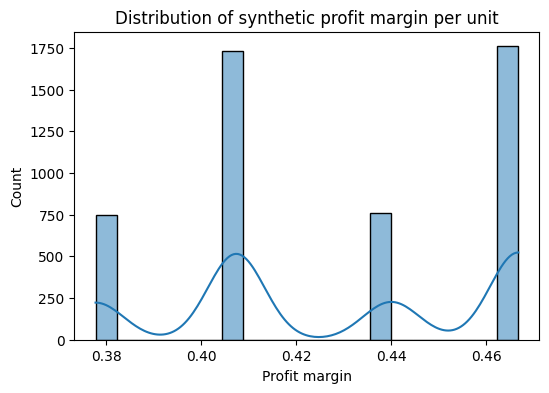

count    5000.000000
mean        0.428802
std         0.032746
min         0.377800
25%         0.407400
50%         0.440000
75%         0.466700
max         0.466700
Name: profit_margin, dtype: float64

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(df["profit_margin"], bins=20, kde=True)
plt.title("Distribution of synthetic profit margin per unit")
plt.xlabel("Profit margin")
plt.show()

# Summary stats
df["profit_margin"].describe()

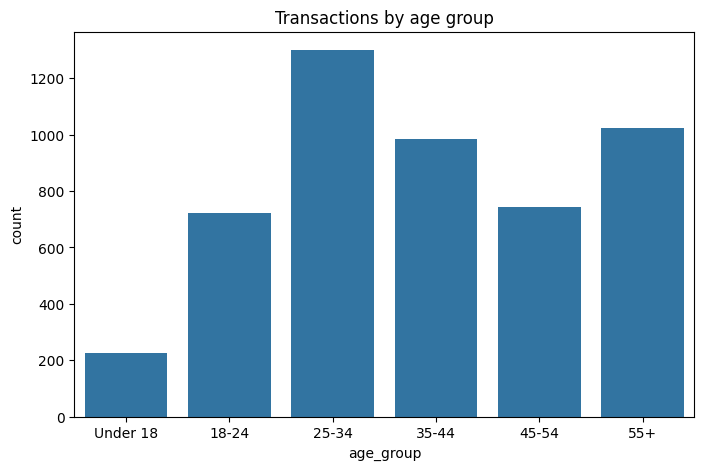

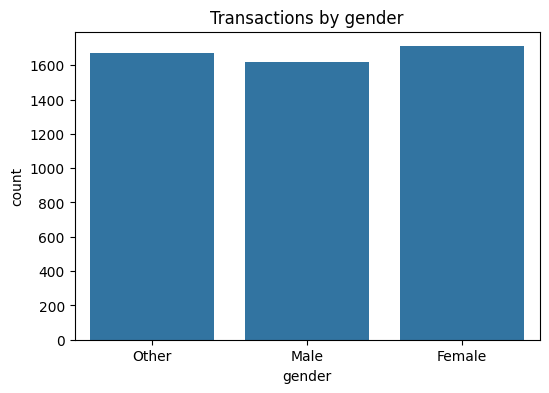

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="age_group", order=["Under 18","18-24","25-34","35-44","45-54","55+"])
plt.title("Transactions by age group")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="gender")
plt.title("Transactions by gender")
plt.show()

In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ---- Download required resources (run once) ----
nltk.download('punkt')
nltk.download('punkt_tab')   # Needed for newer NLTK versions
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ---- Initialize tools ----
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ---- Preprocessing function ----
def preprocess_text(text):
    if pd.isna(text):   # Handle missing values
        return ""
        
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return " ".join(tokens)

# ---- Apply to dataframe ----
df["comment_clean"] = df["comment"].apply(preprocess_text)

df.head(3)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...


,record_id,date,flavour,size,units,price_per_unit,promotion,cost_per_unit,profit_margin,age_group,gender,region,comment,comment_clean
0,1,2024-12-14,Summer Fruits Zero,1.5L,1,2.50,0,1.4,0.4400,55+,Other,London,Zero sugar version tasted nice.,zero sugar version tasted nice
1,2,2024-11-01,Exotic Fruits Zero,500ml,12,1.50,0,0.8,0.4667,55+,Other,Scotland,"Loved the Exotic Fruits Zero, very refreshing!",loved exotic fruit zero refreshing
2,3,2024-08-16,Tropical,500ml,2,1.35,1,0.8,0.4074,55+,Other,South,Great drink for summer days.,great drink summer day


In [8]:
# Limit to top N features to keep dataset manageable
vectorizer = TfidfVectorizer(max_features=50)  # adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(df["comment_clean"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,bottle,buy,citrus,day,drink,enjoyed,exotic,family,favorite,flavour,...,size,snack,sugar,summer,sweet,tasted,tropical,version,wish,zero
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.380287,0.000000,0.0,0.480597,0.000000,0.480597,0.0,0.403063
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.563866,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.363627
2,0.0,0.0,0.0,0.549477,0.549477,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.462555,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.688962,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.380287,0.000000,0.0,0.480597,0.000000,0.480597,0.0,0.403063


In [9]:
# Choose variables for modeling
model_df = df.copy()

# Drop text, keep cleaned text only if needed; drop columns not needed
model_df = model_df.drop(columns=["comment", "comment_clean", "record_id", "date"])

# One-hot encode categorical variables: flavour, size, age_group, gender, region, promotion
model_df = pd.get_dummies(model_df, columns=["flavour", "size", "age_group", "gender", "region", "promotion"], drop_first=True)

# Concatenate TF-IDF features
model_df = pd.concat([model_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

model_df.head()

,units,price_per_unit,cost_per_unit,profit_margin,flavour_Exotic Fruits Zero,flavour_Mango Medley,flavour_Summer Fruits,flavour_Summer Fruits Zero,flavour_Tropical,size_500ml,...,size,snack,sugar,summer,sweet,tasted,tropical,version,wish,zero
0,1,2.50,1.4,0.4400,False,False,False,True,False,False,...,0.0,0.0,0.380287,0.000000,0.0,0.480597,0.000000,0.480597,0.0,0.403063
1,12,1.50,0.8,0.4667,True,False,False,False,False,True,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.363627
2,2,1.35,0.8,0.4074,False,False,False,False,True,True,...,0.0,0.0,0.000000,0.462555,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,1,1.50,0.8,0.4667,False,False,False,False,True,True,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.688962,0.000000,0.0,0.000000
4,1,2.25,1.4,0.3778,False,False,True,False,False,False,...,0.0,0.0,0.380287,0.000000,0.0,0.480597,0.000000,0.480597,0.0,0.403063


In [10]:
# Target: profit_margin
X = model_df.drop(columns=["profit_margin"])
y = model_df["profit_margin"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [11]:
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

# Feature importances
importances = rf_reg.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_importances.head(10)

promotion_1       8.439154e-01
size_500ml        7.096078e-02
cost_per_unit     4.813724e-02
price_per_unit    3.698656e-02
sweet             2.307568e-13
loved             1.887417e-13
refreshing        1.743752e-13
zero              1.724546e-13
fruit             1.602696e-13
units             1.517824e-13
dtype: float64

RMSE: 0.0000
R^2:   1.0000


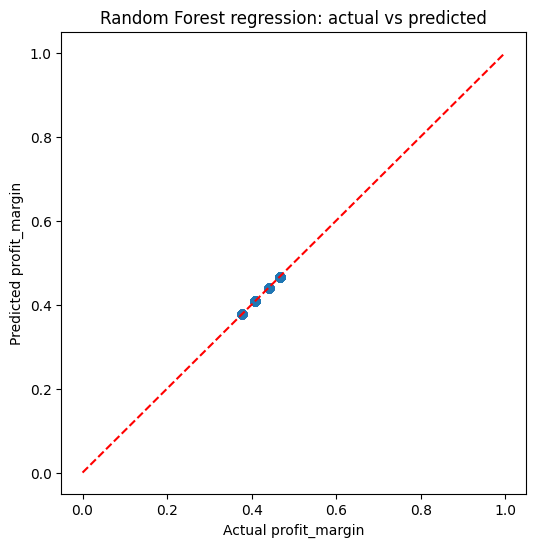

In [12]:
y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R^2:   {r2:.4f}")

# Plot real vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("Actual profit_margin")
plt.ylabel("Predicted profit_margin")
plt.title("Random Forest regression: actual vs predicted")
plt.show()

In [13]:
# Choose threshold, e.g., median
threshold = y.median()
df["high_margin"] = (df["profit_margin"] >= threshold).astype(int)

# Update model_df to include new label
model_df_cls = df.copy()
model_df_cls = model_df_cls.drop(columns=["comment", "comment_clean", "record_id", "date", "profit_margin"])
# Add TF-IDF
model_df_cls = pd.concat([model_df_cls.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# One-hot encode as before
model_df_cls = pd.get_dummies(model_df_cls, columns=["flavour", "size", "age_group", "gender", "region", "promotion"], drop_first=True)

X_cls = model_df_cls.drop(columns=["high_margin"])
y_cls = model_df_cls["high_margin"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.25, random_state=42
)

In [14]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_c, y_train_c)

y_pred_c = rf_clf.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       632
           1       1.00      1.00      1.00       618

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



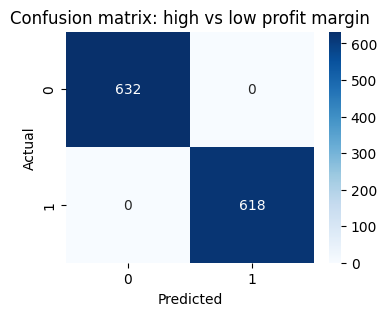

In [15]:
cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix: high vs low profit margin")
plt.show()